In [1]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 3.1 MB/s eta 0:00:00


In [2]:
import FinanceDataReader as fdr

# 삼성전자 -> iMBC

In [6]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
### iMBC 052220 / 기간 최근 2년
df = fdr.DataReader('052220', '2023-01-01', '2025-12-31')
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-01-14,3425,4335,3390,4280,25686985,0.251462
2025-01-15,4175,4970,4155,4215,41799618,-0.015187
2025-01-16,4160,4205,3800,3800,3748919,-0.098458
2025-01-17,3860,3870,3590,3595,2009162,-0.053947
2025-01-20,3600,3820,3535,3550,2160411,-0.012517


# 분석 코드

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

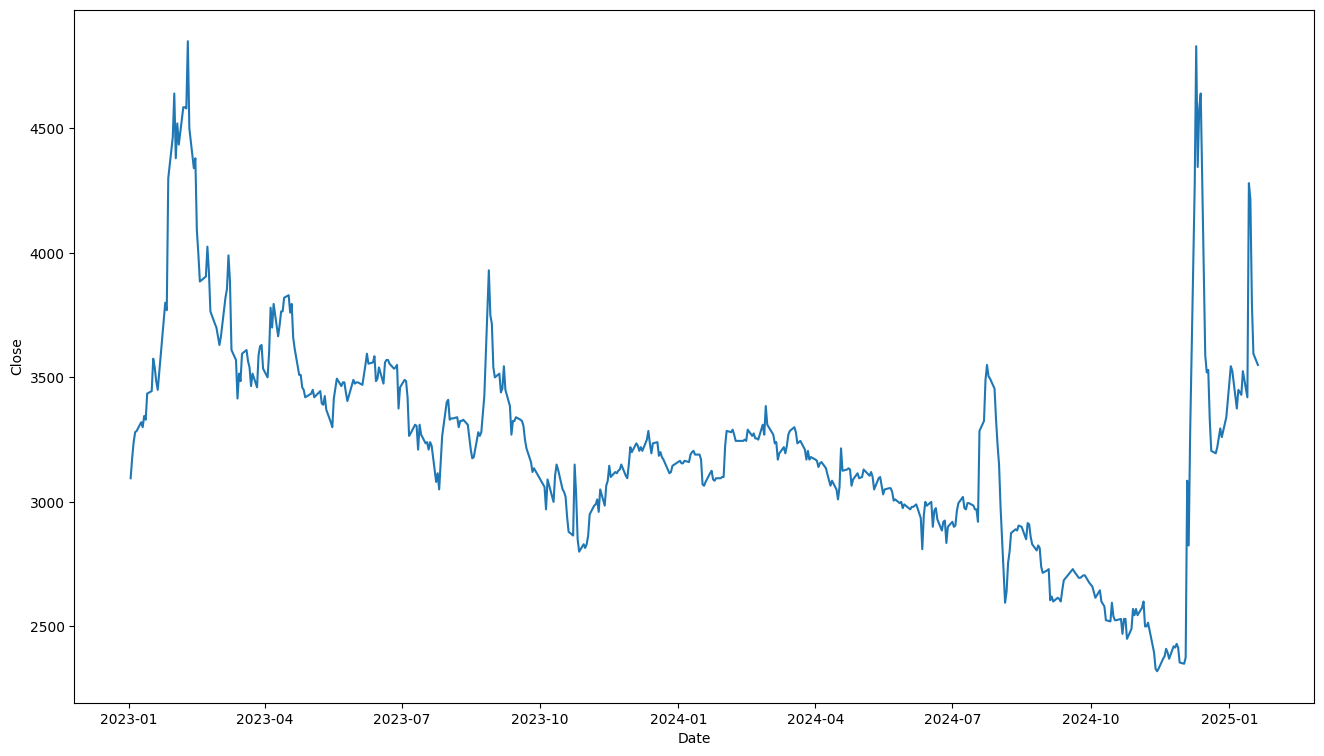

In [8]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()

# 데이터 전처리

In [9]:
#종가 제외 스케일링 (예측변수 = 종가)
## **종가 제외가 된 건지..?
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [10]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length): # (입력 길이 - 시퀀스 길이) 동안
    x_seq.append(x[ i : i + sequence_length]) # 각 시퀀스 추가
    y_seq.append(y[i + sequence_length]) # 출력은 하나

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [11]:
split = 200
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length) # 5일치씩 분리하여 시퀀스 데이터 생성

#순서대로 70개는 학습, 나머지는 평가
## **200개..? 순서대로 200개 학습
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

# 시퀀스 사이즈 : [200개의 시퀀스, 시퀀스 길이, 변수 개수]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-10-650847349e00>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([297, 5, 4]) torch.Size([297, 1])


In [12]:
x_train_seq

tensor([[[0.3228, 0.3173, 0.3519, 0.0046],
         [0.2509, 0.2807, 0.3189, 0.0044],
         [0.3053, 0.3023, 0.3724, 0.0020],
         [0.3140, 0.3322, 0.3930, 0.0031],
         [0.3579, 0.3322, 0.4074, 0.0034]],

        [[0.2509, 0.2807, 0.3189, 0.0044],
         [0.3053, 0.3023, 0.3724, 0.0020],
         [0.3140, 0.3322, 0.3930, 0.0031],
         [0.3579, 0.3322, 0.4074, 0.0034],
         [0.3456, 0.3389, 0.4300, 0.0024]],

        [[0.3053, 0.3023, 0.3724, 0.0020],
         [0.3140, 0.3322, 0.3930, 0.0031],
         [0.3579, 0.3322, 0.4074, 0.0034],
         [0.3456, 0.3389, 0.4300, 0.0024],
         [0.3579, 0.3389, 0.4342, 0.0033]],

        ...,

        [[0.2000, 0.1977, 0.2510, 0.0019],
         [0.2579, 0.3870, 0.2901, 0.2274],
         [0.3018, 0.2990, 0.3128, 0.0232],
         [0.2105, 0.2043, 0.2510, 0.0094],
         [0.1895, 0.1827, 0.2284, 0.0068]],

        [[0.2579, 0.3870, 0.2901, 0.2274],
         [0.3018, 0.2990, 0.3128, 0.0232],
         [0.2105, 0.2043, 0.2510

In [13]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

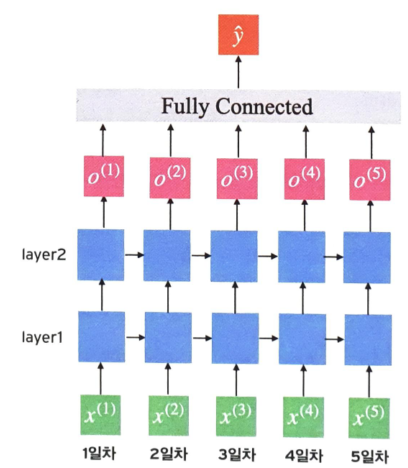

In [14]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2) # 입력 크기 (= 변수 개수 = 4)
num_layers = 2 # 은닉층 2개
hidden_size = 8 # 은닉층 크기

In [15]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
       # nn.RNN(입력 크기 4, 은닉층 크기 8, 은닉층 개수 2, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산
       # nn.Sequential(nn.Linear(은닉층 개수 2 * 시퀀스 사이즈 5, 1), 활성화 함수 nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
       # 초기값 0으로 설정
       # h0 = torch.zeros(2, 4, 8)
    out,_ = self.rnn(x, h0) # RNN : self.rnn(input, hidden layer W(0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out) # 선형변환, 활성화함수
    return out

In [16]:
model = VanillaRNN(input_size=input_size, # 4
                   hidden_size = hidden_size, # 8
                   sequence_length=sequence_length, # 5
                   num_layers=num_layers, # 2
                   device=device).to(device)

In [17]:
criterion = nn.MSELoss() # 손실측정에 MSE 사용
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3) # 최적화에 Adam

## 모델 학습

In [18]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs): # 에폭 50
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산 MSE

    optimizer.zero_grad() #기울기 초기화
    loss.backward() #역전파
    optimizer.step() #최적화
    running_loss += loss.item() #손실 합산

  loss_graph.append(running_loss/n) #에폭 당 평균손실 -> 손실그래프
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0185
[epoch : 10] loss: 0.0046
[epoch : 20] loss: 0.0035
[epoch : 30] loss: 0.0031
[epoch : 40] loss: 0.0028


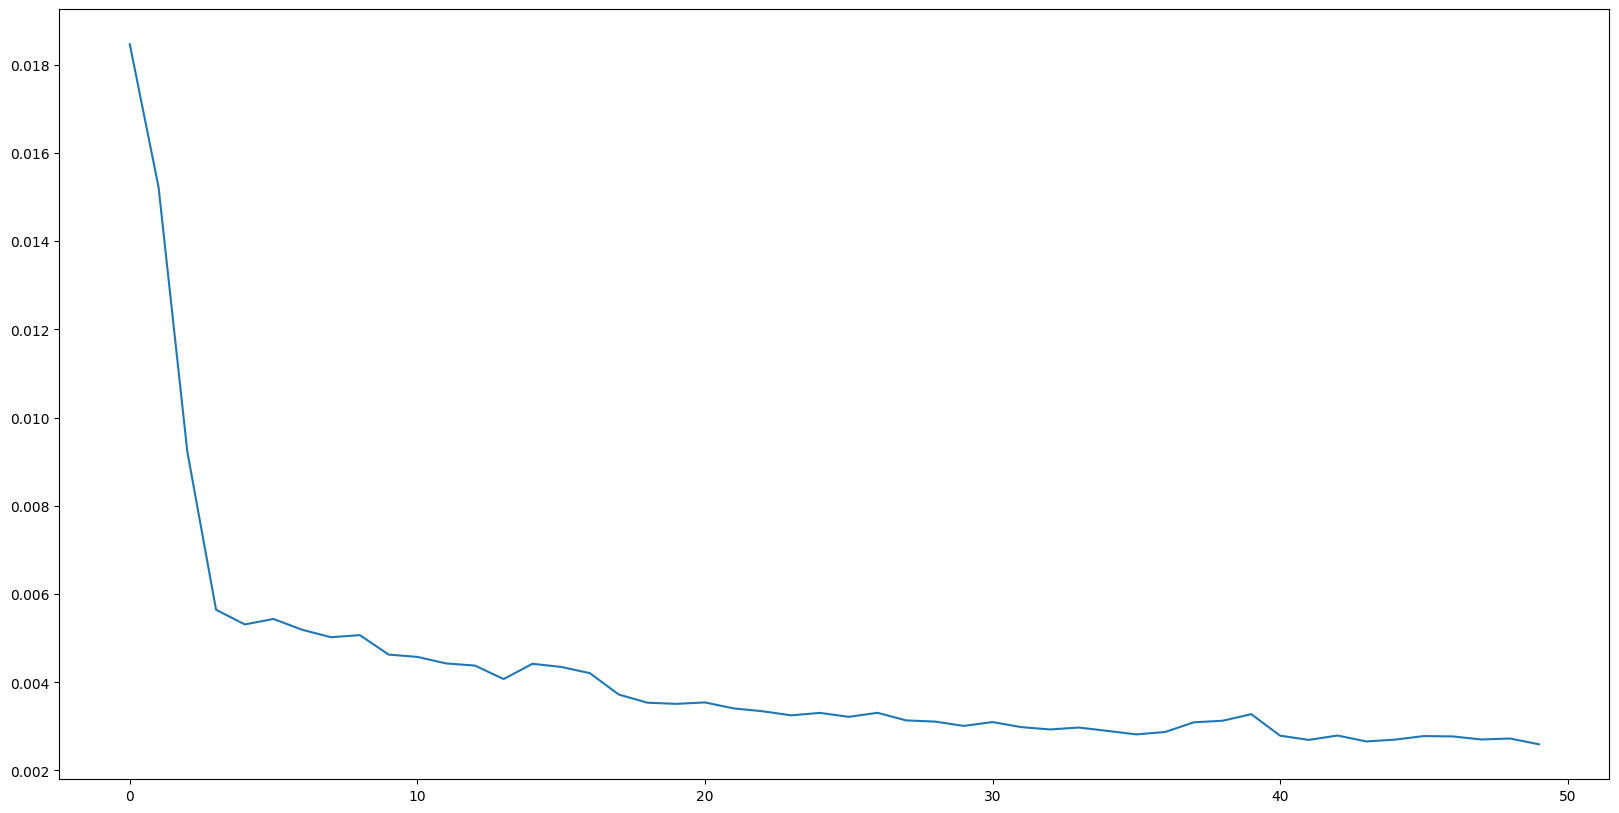

In [19]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [20]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval() # test
  for data in data_loader:
    seq, target = data
    out = model(seq) # 모델 input으로 test 시퀀스 부여
    pred += out.cpu().tolist() # 예측값 붙이기

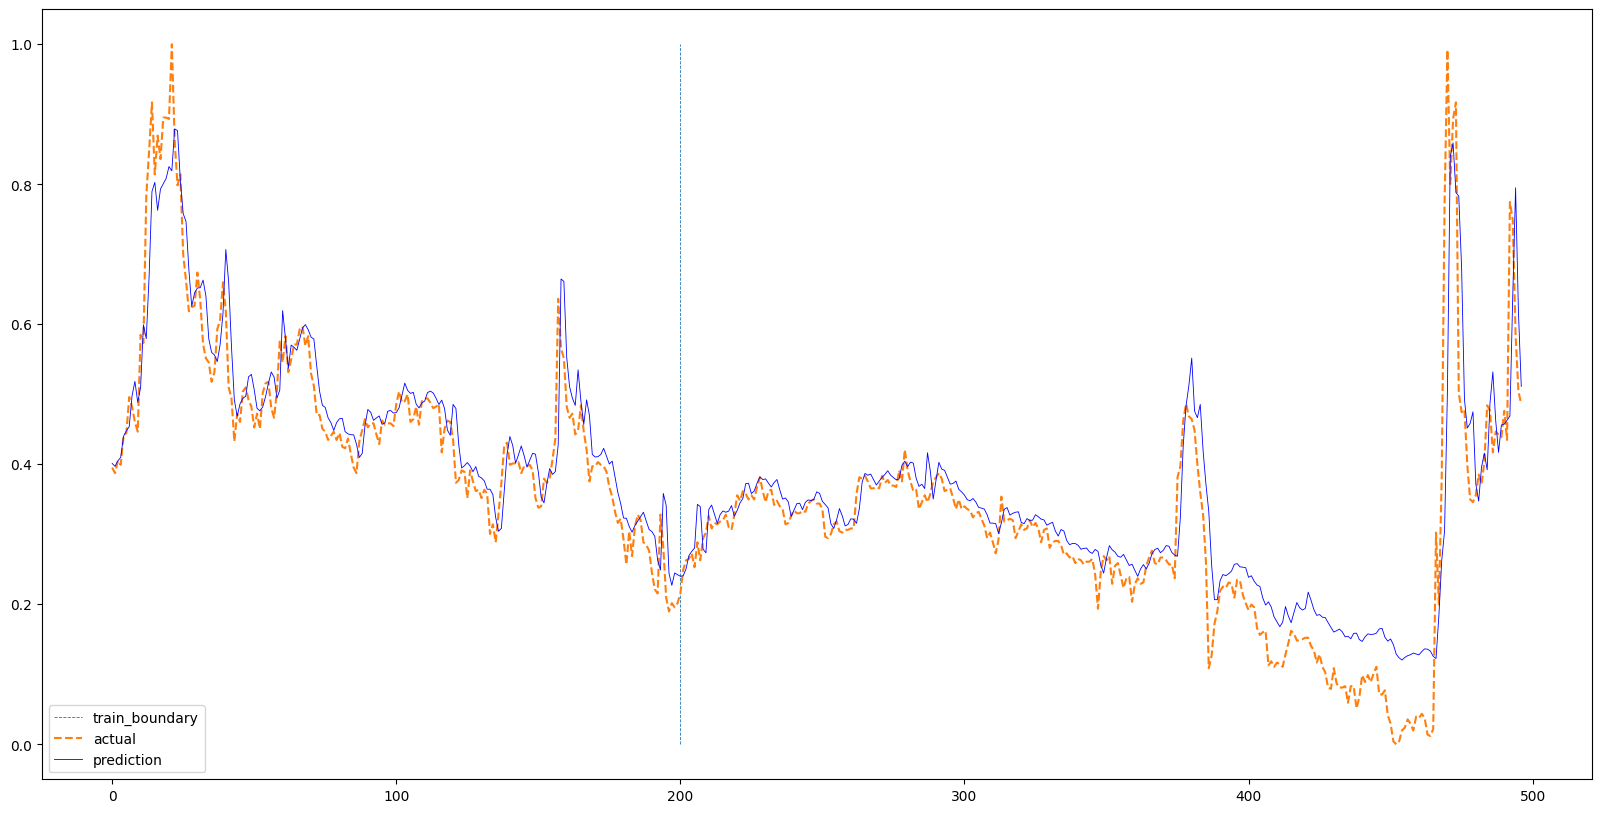

In [21]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [22]:
#하이퍼 파라미터 정의
## vanila와 동일한 파라미터
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [23]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
       # nn.RNN(입력 크기 4, 은닉층 크기 8, 은닉층 개수 2, batch_first=True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)
       # **vanila : nn.Sequential(nn.Linear(2 * 5, 1), 활성화 함수 nn.Sigmoid())
       # **LSTM : nn.Linear(은닉층 개수 2 * 시퀀스 사이즈 5, 1) # 활성화 함수 X
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0)) #**Vanila : self.rnn(x,h0)와 비교
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [24]:
model = LSTM(input_size = input_size, # 4
             hidden_size=hidden_size, # 8
             sequence_length=sequence_length, # 5
             num_layers = num_layers, # 2
             device=device).to(device)

In [25]:
# MSE loss / epoch 50 / Adam optimizer
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [26]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq) # 모델에 시퀀스 데이터 입력
        loss = criterion(out, target) #예측값과 target과의 loss

        optimizer.zero_grad() #기울기 초기화
        loss.backward() #역전파
        optimizer.step() #최적화
        running_loss += loss.item()

    loss_graph.append(running_loss/n) #평균손실 -> 그래프
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.1109
[epoch: 10] loss: 0.0067
[epoch: 20] loss: 0.0054
[epoch: 30] loss: 0.0047
[epoch: 40] loss: 0.0042


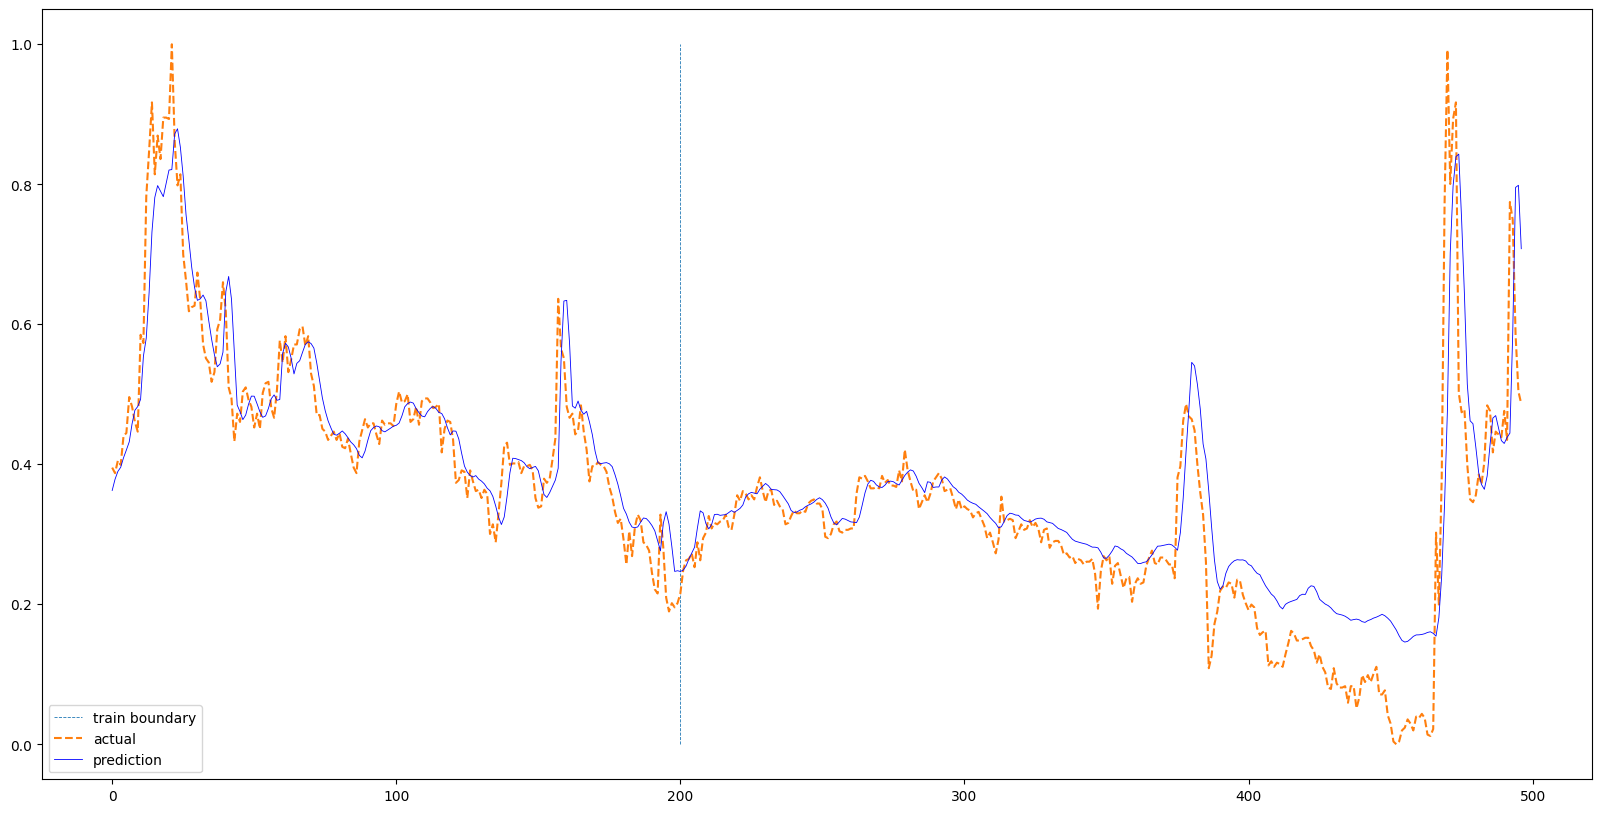

In [27]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

# (Optional)

현대 자동차 주가에 대한 정보에 같은 분석을 해봅시다. 다음 코드를 한 번 실행한 뒤, 분석 코드부터 다시 그대로 돌려보시기 보고 결과에 대해 자유롭게 해석해보시기 바랍니다.

In [ ]:
# 현대자동자 주가로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('005380', '2024-01-01', '2025-12-31')
df.tail